Copyright (c) Microsoft Corporation.

Licensed under the MIT License.

# Model training and evaluation on F3 Netherlands dataset

In this notebook, we will train a deep neural network for facies prediction using F3 Netherlands dataset. The processed F3 data is made available by [Alaudah et al. 2019](https://github.com/olivesgatech/facies_classification_benchmark). 

## Environment setup

To set up the conda environment, please follow the instructions in the top-level [README.md](../../../README.md) file.

__Note__: To register the conda environment in Jupyter, run:
`python -m ipykernel install --user --name envname`

## Library imports

Let's load required libraries.

In [1]:
import logging
import logging.config
from os import path
import random
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})

import yacs.config

import cv2
import numpy as np
import torch
from albumentations import Compose, HorizontalFlip, Normalize, PadIfNeeded, Resize
from ignite.contrib.handlers import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from ignite.engine import Events
from ignite.metrics import Loss
from ignite.utils import convert_tensor
from toolz import compose
from torch.utils import data

from cv_lib.event_handlers import SnapshotHandler, logging_handlers
from cv_lib.segmentation.dutchf3.engine import create_supervised_trainer

from cv_lib.segmentation.dutchf3.utils import (
    current_datetime,
    generate_path,
    git_branch,
    git_hash,
    np_to_tb,
)

from deepseismic_interpretation.dutchf3.data import (
    get_patch_loader,
    decode_segmap,
    get_test_loader,
)

from utilities import (
    plot_aline,
    prepare_batch,
    _patch_label_2d,
    _compose_processing_pipeline,
    _output_processing_pipeline,
    _write_section_file,
    runningScore,
)

# set device
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# number of images to score
N_EVALUATE = 20
# experiment configuration file
CONFIG_FILE = "./configs/patch_deconvnet_skip.yaml"


## Data download and preparation

To download and prepare the F3 data set, please follow the instructions [here](../../../interpretation/dutchf3_patch/README.md). Once you've downloaded and prepared the data set, you'll find your files in the following directory tree:

```
data
├── splits
├── test_once
│   ├── test1_labels.npy
│   ├── test1_seismic.npy
│   ├── test2_labels.npy
│   └── test2_seismic.npy
└── train
    ├── train_labels.npy
    └── train_seismic.npy
```

We recommend saving the data under `/mnt/dutchf3` since this notebook will use that location as the data root. Otherwise, modify the DATASET.ROOT field in the configuration file, described next. 

## Experiment configuration file

We use configuration files to specify experiment configuration, such as hyperparameters used in training and evaluation, as well as other experiment settings. We provide several configuration files for this notebook, under `./configs`, mainly differing in the DNN architecture used for defining the model.

Modify the `CONFIG_FILE` variable above if you would like to run the experiment using a different configuration file.

In [2]:
with open(CONFIG_FILE, "rt") as f_read:
    config = yacs.config.load_cfg(f_read)


## F3 data set 

Let's visualize a few sections of the F3 data set. The processed F3 data set is stored as a 3D numpy array. Let's view slices of the data along inline and crossline directions. 

In [3]:
# Load training data and labels
train_seismic = np.load(path.join(config.DATASET.ROOT, "train/train_seismic.npy"))
train_labels = np.load(path.join(config.DATASET.ROOT, "train/train_labels.npy"))

print(f"Number of inline slices: {train_seismic.shape[0]}")
print(f"Number of crossline slices: {train_seismic.shape[1]}")
print(f"Depth dimension : {train_seismic.shape[2]}")

Number of inline slices: 401
Number of crossline slices: 701
Depth dimension : 255


Let's plot an __inline__ slice.

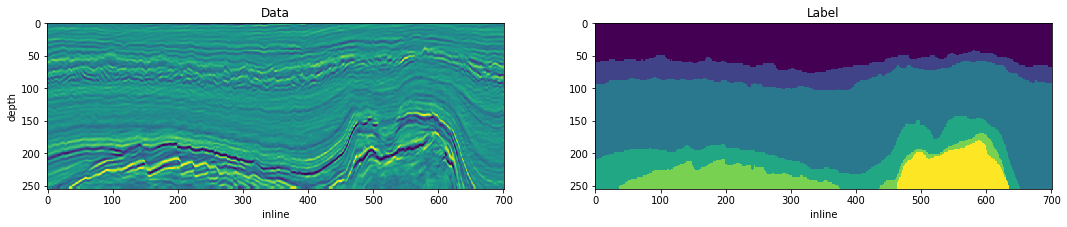

In [4]:
idx = 100
x_in = train_seismic[idx, :, :].swapaxes(0, 1)
x_inl = train_labels[idx, :, :].swapaxes(0, 1)

plot_aline(x_in, x_inl, xlabel="inline")

Let's plot a __crossline__ slice.

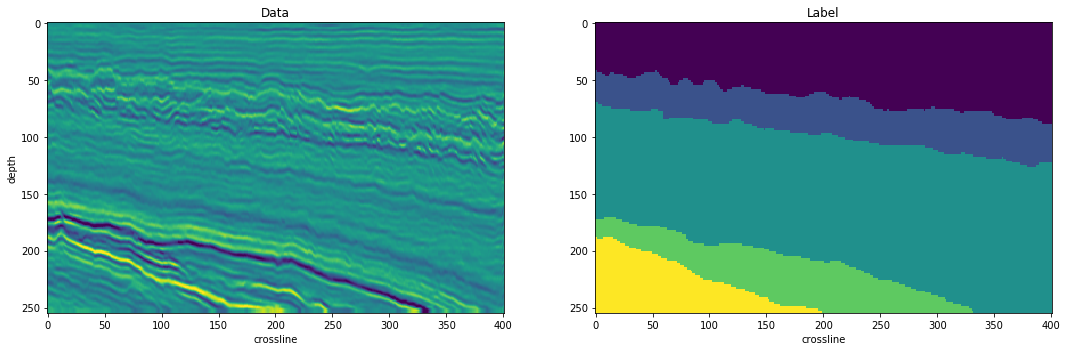

In [5]:
x_cr = train_seismic[:, idx, :].swapaxes(0, 1)
x_crl = train_labels[:, idx, :].swapaxes(0, 1)

plot_aline(x_cr, x_crl, xlabel="crossline")

## Model training

In [6]:
# Set up logging
logging.config.fileConfig(config.LOG_CONFIG)
logger = logging.getLogger(__name__)
logger.debug(config.WORKERS)
torch.backends.cudnn.benchmark = config.CUDNN.BENCHMARK


### Set up data augmentation

Let's define our data augmentation pipeline, which includes basic transformations, such as data normalization, resizing, and padding if necessary. 

In [7]:
# Setup Augmentations
basic_aug = Compose(
    [
        Normalize(
            mean=(config.TRAIN.MEAN,), std=(config.TRAIN.STD,), max_pixel_value=1
        ),
        Resize(
            config.TRAIN.AUGMENTATIONS.RESIZE.HEIGHT,
            config.TRAIN.AUGMENTATIONS.RESIZE.WIDTH,
            always_apply=True,
        ),
        PadIfNeeded(
            min_height=config.TRAIN.AUGMENTATIONS.PAD.HEIGHT,
            min_width=config.TRAIN.AUGMENTATIONS.PAD.WIDTH,
            border_mode=cv2.BORDER_CONSTANT,
            always_apply=True,
            mask_value=255,
        ),
    ]
)

if config.TRAIN.AUGMENTATION:
    train_aug = Compose([basic_aug, HorizontalFlip(p=0.5)])
else:
    train_aug = basic_aug

### Load the data

For training the model, we will use a patch-based approach. Rather than using entire sections (crosslines or inlines) of the data, we extract a large number of small patches from the sections, and use the patches as our data. This allows us to generate larger set of images for training, but is also a more feasible approach for large seismic volumes. 

We created a customer patch data loader for generating and loading patches from our seismic data.

In [8]:
TrainPatchLoader = get_patch_loader(config)

train_set = TrainPatchLoader(
    config.DATASET.ROOT,
    split="train",
    is_transform=True,
    stride=config.TRAIN.STRIDE,
    patch_size=config.TRAIN.PATCH_SIZE,
    augmentations=train_aug,
)


train_loader = data.DataLoader(
    train_set,
    batch_size=config.TRAIN.BATCH_SIZE_PER_GPU,
    num_workers=config.WORKERS,
    shuffle=True,
)


/data/home/vapaunic/repos/DeepSeismic/interpretation/deepseismic_interpretation/dutchf3/data.py:460: UserWarning: This no longer pads the volume
  warnings.warn("This no longer pads the volume")


### Set up model training

Next, let's define a model to train, an optimization algorithm, and a loss function. 

Note that the model is loaded from our `cv_lib` library, using the name of the model as specified in the configuration file. To load a different model, either change the MODEL.NAME field in the configuration file, or create a new one corresponding to the model you wish to train.

In [9]:
# load a model
model = getattr(models, config.MODEL.NAME).get_seg_model(config)

# Send to GPU if available
model = model.to(device)

# SGD optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=config.TRAIN.MAX_LR,
    momentum=config.TRAIN.MOMENTUM,
    weight_decay=config.TRAIN.WEIGHT_DECAY,
)

# learning rate scheduler
scheduler_step = config.TRAIN.END_EPOCH // config.TRAIN.SNAPSHOTS
snapshot_duration = scheduler_step * len(train_loader)
scheduler = CosineAnnealingScheduler(
    optimizer, "lr", config.TRAIN.MAX_LR, config.TRAIN.MIN_LR, snapshot_duration
)

# weights are inversely proportional to the frequency of the classes in the training set
class_weights = torch.tensor(
    config.DATASET.CLASS_WEIGHTS, device=device, requires_grad=False
)

# loss function
criterion = torch.nn.CrossEntropyLoss(
    weight=class_weights, ignore_index=255, reduction="mean"
)

### Training the model

We use [ignite](https://pytorch.org/ignite/index.html) framework to create training and validation loops in our codebase. Ignite provides an easy way to create compact training/validation loops without too much boilerplate code.

In this notebook, we demonstrate the use of ignite on the training loop only. We create a training engine `trainer`, that loops multiple times over the training dataset and updates model parameters. In addition, we add various events to the trainer, using an event system, that allows us to interact with the engine on each step of the run, such as, when the trainer is started/completed, when the epoch is started/completed and so on. 

In the cell below, we use event handlers to log training output, log and schedule learning rate, and periodically save model to disk.

In [10]:
# create training engine
trainer = create_supervised_trainer(
    model, optimizer, criterion, prepare_batch, device=device
)

# add learning rate scheduler
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)

# add logging of traininig output
trainer.add_event_handler(
    Events.ITERATION_COMPLETED,
    logging_handlers.log_training_output(log_interval=config.PRINT_FREQ),
)

# add logging of learning rate
trainer.add_event_handler(Events.EPOCH_STARTED, logging_handlers.log_lr(optimizer))

# add model checkpointing
output_dir = path.join(config.OUTPUT_DIR, config.TRAIN.MODEL_DIR)
checkpoint_handler = ModelCheckpoint(
    output_dir, "model", save_interval=2, n_saved=3, create_dir=True, require_empty=False
)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED, checkpoint_handler, {config.MODEL.NAME: model}
)

Start the training engine run.

In [11]:
trainer.run(train_loader, max_epochs=config.TRAIN.END_EPOCH)

2019-09-25 18:19:05,213 - ignite.engine.engine.Engine - INFO - Engine run starting with max_epochs=10.
2019-09-25 18:19:05,214 - cv_lib.event_handlers.logging_handlers - INFO - lr - [0.02]
2019-09-25 18:19:27,468 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 1 Iter: 50 loss 0.7012420892715454
2019-09-25 18:19:46,513 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 1 Iter: 100 loss 0.28899359703063965
2019-09-25 18:20:05,579 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 1 Iter: 150 loss 0.173098623752594
2019-09-25 18:20:24,618 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 1 Iter: 200 loss 0.17099666595458984
2019-09-25 18:20:43,668 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 1 Iter: 250 loss 0.08583173900842667
2019-09-25 18:21:02,722 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 1 Iter: 300 loss 0.0811498835682869
2019-09-25 18:21:21,772 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 1 Iter: 350 loss 0.14504070

2019-09-25 18:40:48,921 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 5 Iter: 3400 loss 0.043800223618745804
2019-09-25 18:41:08,003 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 5 Iter: 3450 loss 0.039736416190862656
2019-09-25 18:41:27,081 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 5 Iter: 3500 loss 0.038158830255270004
2019-09-25 18:41:30,841 - ignite.engine.engine.Engine - INFO - Epoch[5] Complete. Time taken: 00:04:27
2019-09-25 18:41:30,842 - cv_lib.event_handlers.logging_handlers - INFO - lr - [0.01052125719751]
2019-09-25 18:41:46,253 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 6 Iter: 3550 loss 0.04899909719824791
2019-09-25 18:42:05,331 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 6 Iter: 3600 loss 0.04364394396543503
2019-09-25 18:42:24,410 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 6 Iter: 3650 loss 0.04946207255125046
2019-09-25 18:42:43,516 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 6

2019-09-25 19:02:10,947 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 10 Iter: 6750 loss 0.03194150701165199
2019-09-25 19:02:30,038 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 10 Iter: 6800 loss 0.029924677684903145
2019-09-25 19:02:49,132 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 10 Iter: 6850 loss 0.03403583541512489
2019-09-25 19:03:08,225 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 10 Iter: 6900 loss 0.032861556857824326
2019-09-25 19:03:27,314 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 10 Iter: 6950 loss 0.0374293178319931
2019-09-25 19:03:46,406 - cv_lib.event_handlers.logging_handlers - INFO - Epoch: 10 Iter: 7000 loss 0.031759023666381836
2019-09-25 19:03:53,986 - ignite.engine.engine.Engine - INFO - Epoch[10] Complete. Time taken: 00:04:28
2019-09-25 19:03:55,106 - ignite.engine.engine.Engine - INFO - Engine run complete. Time taken 00:44:49


## Evaluation

We will next evaluate the performance of the model by looking at how well it predicts facies labels on samples from the test set.

We will use the following evaluation metrics:

- Pixel Accuracy (PA)
- Class Accuracy (CA)
- Mean Class Accuracy (MCA)
- Frequency Weighted intersection-over-union (FW IoU)
- Mean IoU (MIoU)

Let's first load the model saved previously.

In [12]:
model = getattr(models, config.MODEL.NAME).get_seg_model(config)
model.load_state_dict(torch.load(config.TEST.MODEL_PATH), strict=False)
model = model.to(device)


Next we load the test data and define the augmentations on it. 

In [13]:
# Augmentation
section_aug = Compose(
    [Normalize(mean=(config.TRAIN.MEAN,), std=(config.TRAIN.STD,), max_pixel_value=1)]
)

patch_aug = Compose(
    [
        Resize(
            config.TRAIN.AUGMENTATIONS.RESIZE.HEIGHT,
            config.TRAIN.AUGMENTATIONS.RESIZE.WIDTH,
            always_apply=True,
        ),
        PadIfNeeded(
            min_height=config.TRAIN.AUGMENTATIONS.PAD.HEIGHT,
            min_width=config.TRAIN.AUGMENTATIONS.PAD.WIDTH,
            border_mode=cv2.BORDER_CONSTANT,
            always_apply=True,
            mask_value=255,
        ),
    ]
)

# Process test data
pre_processing = _compose_processing_pipeline(config.TRAIN.DEPTH, aug=patch_aug)
output_processing = _output_processing_pipeline(config)

# Select the test split
split = "test1" if "both" in config.TEST.SPLIT else config.TEST.SPLIT

labels = np.load(path.join(config.DATASET.ROOT, "test_once", split + "_labels.npy"))
section_file = path.join(config.DATASET.ROOT, "splits", "section_" + split + ".txt")
_write_section_file(labels, section_file, config)

# Load test data
TestSectionLoader = get_test_loader(config)
test_set = TestSectionLoader(
    config.DATASET.ROOT, split=split, is_transform=True, augmentations=section_aug
)

test_loader = data.DataLoader(
    test_set, batch_size=1, num_workers=config.WORKERS, shuffle=False
)


### Predict segmentation mask on the test data

In [14]:
_CLASS_NAMES = [
    "upper_ns",
    "middle_ns",
    "lower_ns",
    "rijnland_chalk",
    "scruff",
    "zechstein",
]

n_classes = len(_CLASS_NAMES)

# keep only N_EVALUATE sections to score
test_subset = random.sample(list(test_loader), N_EVALUATE)

results = list()
running_metrics_split = runningScore(n_classes)

# testing mode
with torch.no_grad():
    model.eval()
    # loop over testing data
    for i, (images, labels) in enumerate(test_subset):
        logger.info(f"split: {split}, section: {i}")
        outputs = _patch_label_2d(
            model,
            images,
            pre_processing,
            output_processing,
            config.TRAIN.PATCH_SIZE,
            config.TEST.TEST_STRIDE,
            config.VALIDATION.BATCH_SIZE_PER_GPU,
            device,
            n_classes,
        )

        pred = outputs.detach().max(1)[1].numpy()
        gt = labels.numpy()
        
        # update evaluation metrics
        running_metrics_split.update(gt, pred)
        
        # keep ground truth and result for plotting
        results.append((np.squeeze(gt), np.squeeze(pred)))
        

2019-09-25 19:50:17,990 - __main__ - INFO - split: test1, section: 0
2019-09-25 19:50:25,205 - __main__ - INFO - split: test1, section: 1
2019-09-25 19:50:25,851 - __main__ - INFO - split: test1, section: 2
2019-09-25 19:50:26,497 - __main__ - INFO - split: test1, section: 3
2019-09-25 19:50:27,142 - __main__ - INFO - split: test1, section: 4
2019-09-25 19:50:27,789 - __main__ - INFO - split: test1, section: 5
2019-09-25 19:50:28,437 - __main__ - INFO - split: test1, section: 6
2019-09-25 19:50:29,093 - __main__ - INFO - split: test1, section: 7
2019-09-25 19:50:47,011 - __main__ - INFO - split: test1, section: 8
2019-09-25 19:50:49,830 - __main__ - INFO - split: test1, section: 9
2019-09-25 19:50:50,473 - __main__ - INFO - split: test1, section: 10
2019-09-25 19:50:51,115 - __main__ - INFO - split: test1, section: 11
2019-09-25 19:50:51,759 - __main__ - INFO - split: test1, section: 12
2019-09-25 19:50:52,410 - __main__ - INFO - split: test1, section: 13
2019-09-25 19:50:53,061 - __ma

Let's view the obtained metrics on this subset of test images.

In [15]:
# get scores
score, _ = running_metrics_split.get_scores()

# Log split results
print(f'Pixel Acc: {score["Pixel Acc: "]:.3f}')
for cdx, class_name in enumerate(_CLASS_NAMES):
    print(f'  {class_name}_accuracy {score["Class Accuracy: "][cdx]:.3f}')

print(f'Mean Class Acc: {score["Mean Class Acc: "]:.3f}')
print(f'Freq Weighted IoU: {score["Freq Weighted IoU: "]:.3f}')
print(f'Mean IoU: {score["Mean IoU: "]:0.3f}')

Pixel Acc: 0.821
  upper_ns_accuracy 0.979
  middle_ns_accuracy 0.894
  lower_ns_accuracy 0.969
  rijnland_chalk_accuracy 0.794
  scruff_accuracy 0.309
  zechstein_accuracy 0.662
Mean Class Acc: 0.768
Freq Weighted IoU: 0.689
Mean IoU: 0.638


### Visualize predictions

Let's visualize the predictions on entire test sections. Note that the crosslines and inlines have different dimensions, however we were able to use them jointly for our network training and evaluation, since we were using smaller patches from the sections, whose size we can control via hyperparameter in the experiment configuration file. 

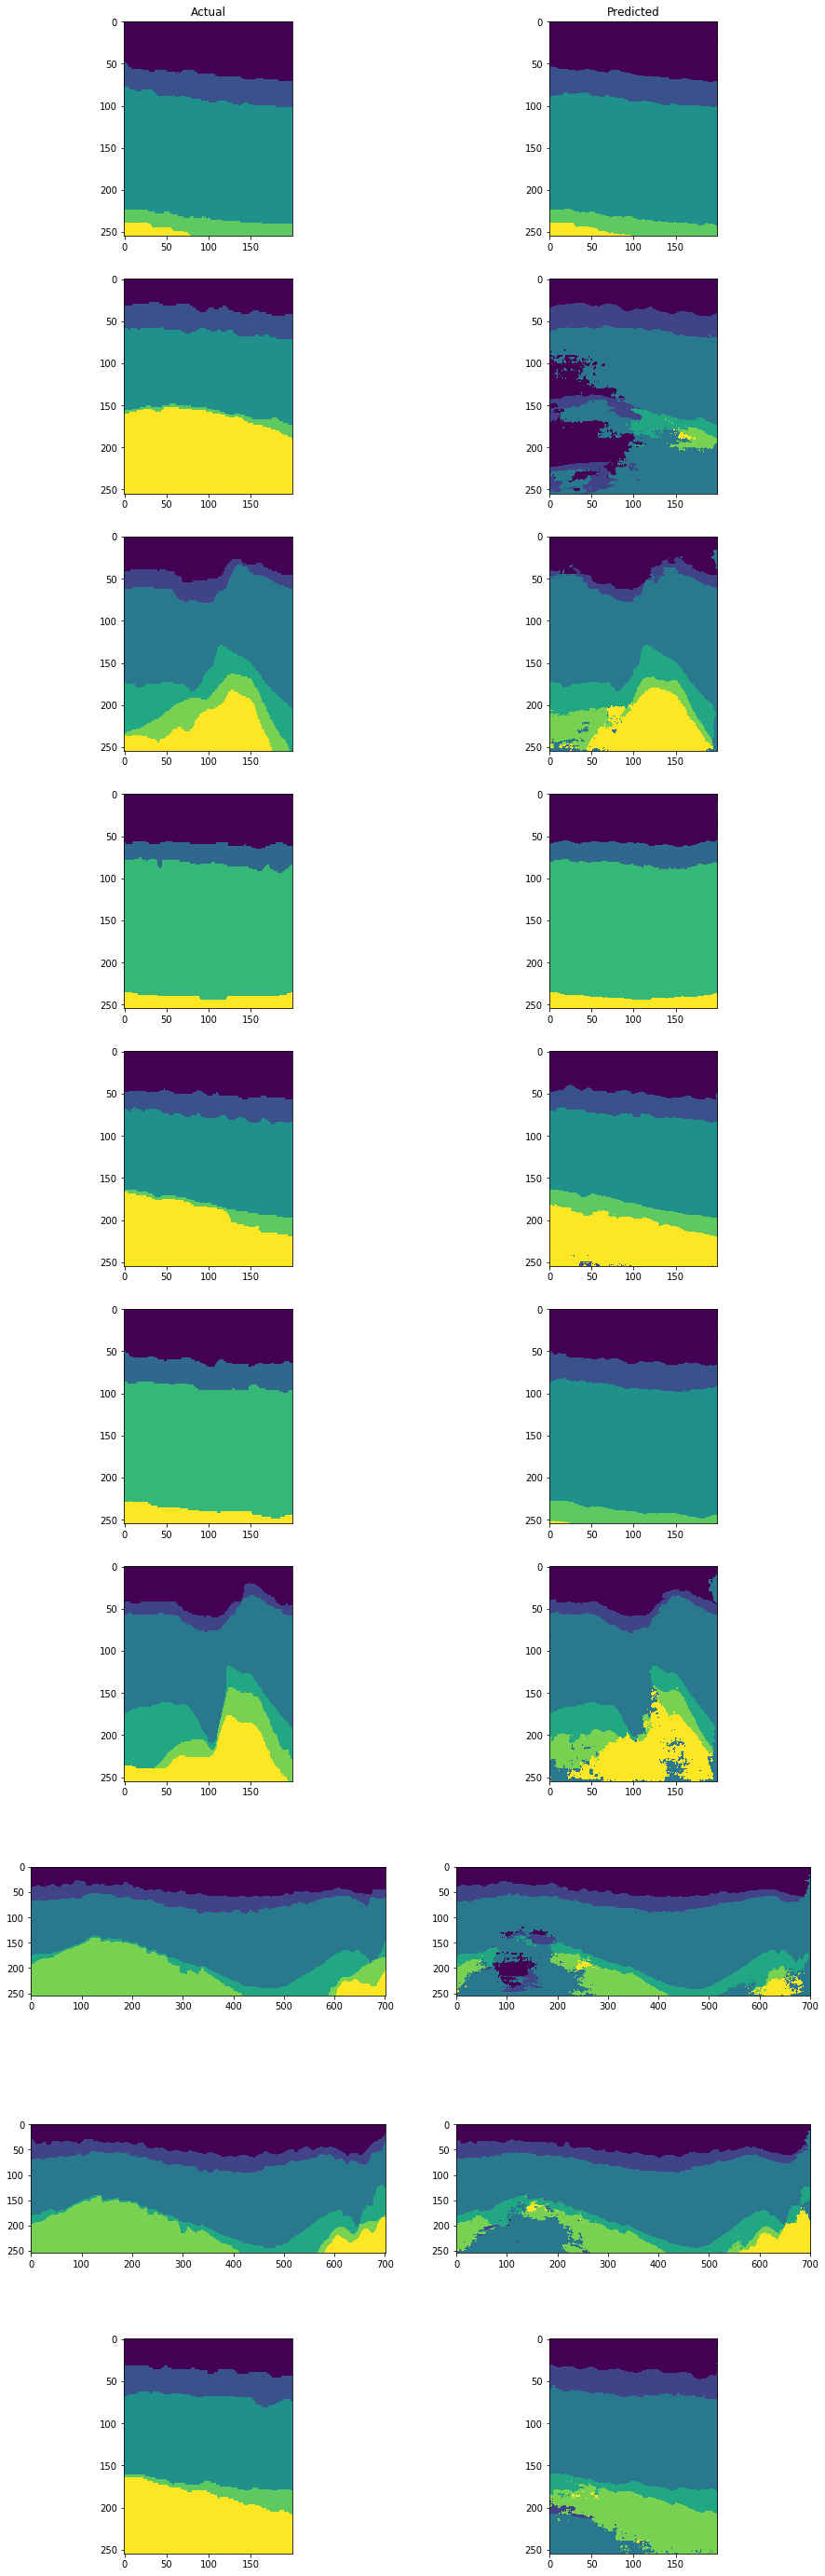

In [16]:
fig = plt.figure(figsize=(15,50))

nplot = min(N_EVALUATE, 10)
for idx in range(nplot):
    # plot actual
    plt.subplot(nplot, 2, 2*(idx+1)-1)
    plt.imshow(results[idx][0])
    # plot predicted
    plt.subplot(nplot, 2, 2*(idx+1))
    plt.imshow(results[idx][1])

f_axes = fig.axes
_ = f_axes[0].set_title('Actual')
_ = f_axes[1].set_title('Predicted')    